In [1]:
import numpy as np
np.random.seed(4)
import matplotlib.pyplot as plt
import pandas as pd
from perfil_binance import cuenta_binance as cb 
from Datasets import historical

In [2]:
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense, LSTM

In [3]:
#
# Funciones auxiliares
#
def graficar_predicciones(real, prediccion):
    plt.plot(real[0:len(prediccion)],color='red', label='Valor real de la acción')
    plt.plot(prediccion, color='blue', label='Predicción de la acción')
    plt.ylim(1.1 * np.min(prediccion)/2, 1.1 * np.max(prediccion))
    plt.xlabel('Tiempo')
    plt.ylabel('Valor de la acción')
    plt.legend()
    plt.show()

In [7]:
#
# Lectura de los datos
#
#dataset = pd.read_csv('../DataSets/AAPL_2006-01-01_to_2018-01-01.csv', index_col='Date', parse_dates=['Date'])
real = cb('real')
dataset = historical(real, 'TRXUSDT', '30m', limite=1000)
dataset.head()

---------Cuenta real----------


,open_time,open,high,low,close,volumen,close_time,quote_asset_v,num_trades,taker_buy_base_asset_v,taker_buy_quote_asset_v,ignore
0,2022-07-22 13:00:00,0.06750,0.06751,0.06734,0.06750,7273530.7,2022-07-22 13:29:59.999,4.903937e+05,1788,4054707.8,273377.784662,0
1,2022-07-22 13:30:00,0.06749,0.06765,0.06745,0.06760,6448237.2,2022-07-22 13:59:59.999,4.356552e+05,1582,3153861.4,213100.388205,0
2,2022-07-22 14:00:00,0.06760,0.06767,0.06752,0.06756,7061567.2,2022-07-22 14:29:59.999,4.772388e+05,1530,3647455.5,246508.969124,0
3,2022-07-22 14:30:00,0.06757,0.06757,0.06682,0.06685,27610858.3,2022-07-22 14:59:59.999,1.851986e+06,5139,11314641.8,758733.054230,0
4,2022-07-22 15:00:00,0.06685,0.06688,0.06668,0.06681,13827548.3,2022-07-22 15:29:59.999,9.233178e+05,3066,7237565.5,483291.030970,0


In [14]:
dataset.iloc[900:, [0,4]]

,open_time,close
900,2022-08-10 07:00:00,0.06882
901,2022-08-10 07:30:00,0.07021
902,2022-08-10 08:00:00,0.07035
903,2022-08-10 08:30:00,0.07028
904,2022-08-10 09:00:00,0.07016
...,...,...
995,2022-08-12 06:30:00,0.06950
996,2022-08-12 07:00:00,0.06955
997,2022-08-12 07:30:00,0.06967
998,2022-08-12 08:00:00,0.06968


In [11]:
dataset.shape

(1000, 12)

In [16]:
#
# Sets de entrenamiento y validación 
# La LSTM se entrenará con datos de 2016 hacia atrás. La validación se hará con datos de 2017 en adelante.
# En ambos casos sólo se usará el valor más alto de la acción para cada día
#
set_entrenamiento = dataset.iloc[0:899,[0,4]]
set_validacion = dataset.iloc[900:,[0,4]]

In [17]:
set_entrenamiento.head(3)

,open_time,close
0,2022-07-22 13:00:00,0.06750
1,2022-07-22 13:30:00,0.06760
2,2022-07-22 14:00:00,0.06756


In [18]:
set_validacion.head()

,open_time,close
900,2022-08-10 07:00:00,0.06882
901,2022-08-10 07:30:00,0.07021
902,2022-08-10 08:00:00,0.07035
903,2022-08-10 08:30:00,0.07028
904,2022-08-10 09:00:00,0.07016


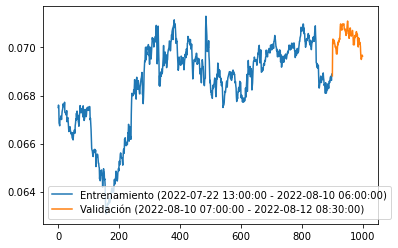

In [22]:
set_entrenamiento['close'].plot(legend=True)
set_validacion['close'].plot(legend=True)
plt.legend([f'Entrenamiento ({set_entrenamiento.open_time.min()} - {set_entrenamiento.open_time.max()})', 
            f'Validación ({set_validacion.open_time.min()} - {set_validacion.open_time.max()})'])
plt.show()

In [28]:
set_entrenamiento.index = set_entrenamiento.open_time
set_entrenamiento.pop('open_time')

open_time
2022-07-22 13:00:00   2022-07-22 13:00:00
2022-07-22 13:30:00   2022-07-22 13:30:00
2022-07-22 14:00:00   2022-07-22 14:00:00
2022-07-22 14:30:00   2022-07-22 14:30:00
2022-07-22 15:00:00   2022-07-22 15:00:00
                              ...        
2022-08-10 04:00:00   2022-08-10 04:00:00
2022-08-10 04:30:00   2022-08-10 04:30:00
2022-08-10 05:00:00   2022-08-10 05:00:00
2022-08-10 05:30:00   2022-08-10 05:30:00
2022-08-10 06:00:00   2022-08-10 06:00:00
Name: open_time, Length: 899, dtype: datetime64[ns]

In [29]:
set_entrenamiento

,close
open_time,
2022-07-22 13:00:00,0.06750
2022-07-22 13:30:00,0.06760
2022-07-22 14:00:00,0.06756
2022-07-22 14:30:00,0.06685
2022-07-22 15:00:00,0.06681
...,...
2022-08-10 04:00:00,0.06878
2022-08-10 04:30:00,0.06880
2022-08-10 05:00:00,0.06870


In [30]:
# Normalización del set de entrenamiento
sc = MinMaxScaler(feature_range=(0,1))
set_entrenamiento_escalado = sc.fit_transform(set_entrenamiento)

In [51]:
# La red LSTM tendrá como entrada "time_step" datos consecutivos, 
# y como salida 1 dato (la predicción a partir de esos "time_step" datos). 
# Se conformará de esta forma el set de entrenamiento
time_step = 20
X_train = []
Y_train = []
m = len(set_entrenamiento_escalado)


for i in range(time_step,m):
    # X: bloques de "time_step" datos: 0-time_step, 1-time_step+1, 2-time_step+2, etc
    #print(i)
    X_train.append(set_entrenamiento_escalado[i-time_step:i,0])

    # Y: el siguiente dato
    Y_train.append(set_entrenamiento_escalado[i,0])

In [52]:
Y_train

[0.5407047387606303,
 0.5650060753341437,
 0.5127582017010939,
 0.5127582017010939,
 0.5115431348724178,
 0.5115431348724178,
 0.5006075334143381,
 0.5006075334143381,
 0.5224787363304975,
 0.46658566221142106,
 0.4848116646415539,
 0.4848116646415539,
 0.4872417982989061,
 0.46051032806804404,
 0.439854191980559,
 0.41676792223572345,
 0.42162818955042436,
 0.4252733900364527,
 0.43620899149453063,
 0.4410692588092333,
 0.4240583232077748,
 0.41555285540704556,
 0.40461725394896764,
 0.4082624544349942,
 0.41190765492102077,
 0.39975698663426495,
 0.39246658566221004,
 0.3815309842041321,
 0.41069258809234466,
 0.3742405832320772,
 0.3961117861482384,
 0.41190765492102077,
 0.4191980558930739,
 0.4240583232077748,
 0.4240583232077748,
 0.4082624544349942,
 0.4471445929526121,
 0.4592952612393679,
 0.4799513973268512,
 0.4750911300121503,
 0.5091130012150655,
 0.4848116646415539,
 0.5200486026731452,
 0.49939246658566194,
 0.4811664641555291,
 0.49817739975698583,
 0.4678007290400954,


In [53]:
X_train, Y_train = np.array(X_train), np.array(Y_train)

In [54]:
# Reshape X_train para que se ajuste al modelo en Keras
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))

In [55]:
X_train.shape

(879, 20, 1)

In [56]:
#
# Red LSTM
#
dim_entrada = (X_train.shape[1],1)
dim_salida = 1
na = 50

modelo = Sequential()
modelo.add(LSTM(units=na, input_shape=dim_entrada))
modelo.add(Dense(units=dim_salida))
modelo.compile(optimizer='rmsprop', loss='mse')
modelo.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_1 (LSTM)               (None, 50)                10400     
                                                                 
 dense_1 (Dense)             (None, 1)                 51        
                                                                 
Total params: 10,451
Trainable params: 10,451
Non-trainable params: 0
_________________________________________________________________


In [57]:
modelo.fit(X_train,Y_train,epochs=20,batch_size=32)

Epoch 1/20
28/28 [==============================] - 3s 9ms/step - loss: 0.0554
Epoch 2/20
28/28 [==============================] - 0s 9ms/step - loss: 0.0060
Epoch 3/20
28/28 [==============================] - 0s 8ms/step - loss: 0.0049
Epoch 4/20
28/28 [==============================] - 0s 8ms/step - loss: 0.0043
Epoch 5/20
28/28 [==============================] - 0s 9ms/step - loss: 0.0040
Epoch 6/20
28/28 [==============================] - 0s 8ms/step - loss: 0.0037
Epoch 7/20
28/28 [==============================] - 1s 24ms/step - loss: 0.0031
Epoch 8/20
28/28 [==============================] - 0s 9ms/step - loss: 0.0027
Epoch 9/20
28/28 [==============================] - 0s 9ms/step - loss: 0.0026
Epoch 10/20
28/28 [==============================] - 0s 9ms/step - loss: 0.0025
Epoch 11/20
28/28 [==============================] - 0s 8ms/step - loss: 0.0025
Epoch 12/20
28/28 [==============================] - 0s 8ms/step - loss: 0.0023
Epoch 13/20
28/28 [=============================

In [58]:
set_validacion.index = set_validacion.open_time
set_validacion.pop('open_time')
set_validacion

AttributeError: 'DataFrame' object has no attribute 'open_time'

In [59]:
#
# Validación (predicción del valor de las acciones)
#
x_test = set_validacion.values
x_test = sc.transform(x_test)

C:\Users\52551\anaconda3\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


In [61]:
X_test = []
for i in range(time_step,len(x_test)):
    X_test.append(x_test[i-time_step:i,0])
X_test = np.array(X_test)
X_test = np.reshape(X_test, (X_test.shape[0],X_test.shape[1],1))

In [65]:
X_test.shape, X_train.shape

((80, 20, 1), (879, 20, 1))

In [62]:
prediccion = modelo.predict(X_test)
prediccion = sc.inverse_transform(prediccion)

3/3 [==============================] - 0s 5ms/step


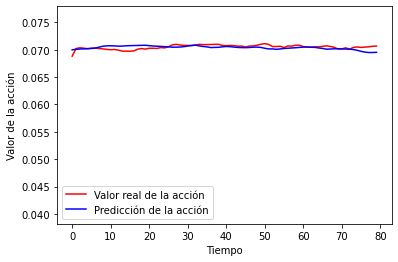

In [63]:
# Graficar resultados
graficar_predicciones(set_validacion.values,prediccion)

In [47]:
modelo.save('lstm_pred_acciones.h5')